In [43]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
from scipy import stats
from scipy import optimize
from scipy.linalg import block_diag

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, List, Tuple


import cvxpy as cp

"""
Own packages
"""
from codelib.portfolio_optimization.risk_metrics import drawdown, maxdrawdown, calculate_conditional_value_at_risk

from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix


from codelib.portfolio_optimization.mean_variance import portfolio_mean, portfolio_std, portfolio_variance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercises - Week 8


## Problem 1: Simulating utility loss

In this exercise, we will simulate the utility loss of different portfolio optimization strategies.

__Question 1__

Generate data using the following code:

In [44]:
# set random seed for reproducibility
np.random.seed(42)

# number of assets
num_assets = 20

# generate random beta coefficients between 0.5 and 1.5
betas = np.random.uniform(0.5, 1.5, num_assets)

# market parameters
rf = 0.02 / 12  # risk-free rate
market_return = 0.08 / 12  # expected market return
market_excess_return = market_return - rf
market_std = 0.15  / np.sqrt(12) # market standard deviation

# draw idiosyncratic std for each asset between 0.05 and 0.1
idiosyncratic_stds = np.random.uniform(0.05 / np.sqrt(12), 0.1 / np.sqrt(12), num_assets)

# draw alpha for each asset between -0.01 and 0.03
alphas = np.random.uniform(-0.03 / 12, 0.03 / 12, num_assets)

# calculate vector of expected returns and covariance matrix
mu = alphas + rf + betas * market_excess_return
mu_excess = mu - rf
cov_mat = np.diag(idiosyncratic_stds**2) + np.outer(betas, betas) * market_std**2
corr_mat = cov_to_corr_matrix(cov_mat)
vols = np.sqrt(np.diag(cov_mat))

Calculate the naive "1/N" portfolio and the mean-variance efficient portfolio with $\lambda = 5$ (using true parameters)

\begin{equation*}
    \boldsymbol{w}^* = \underset{\boldsymbol{w}}{\text{arg max }} \boldsymbol{w}^\top \boldsymbol{\mu} - \frac{\lambda}{2 } \boldsymbol{w}^\top \boldsymbol{\Sigma} \boldsymbol{w}
\end{equation*}

with the constraints

* $\boldsymbol{w} \geq 0$
* $\boldsymbol{w}^\top \boldsymbol{1} = 1$
* $\boldsymbol{w} \leq 0.2$ (max 20% allocation to a single asset)

Note that $\boldsymbol{\mu}$ is the expected return, not excess return.



__Question 2__

Calculate the utility of the two portfolios.


__Question 3__

Simulate the mean-variance loss for the two portfolios . Assume a sample size of 120. Use 10,000 simulations. What are your conclusions?

Note: We can use the normal distribution and the Wishart distribution to simulate respectively sample means and sample covariances. We have true mean and covariance of the data.

__Question 4__

Repeat the analysis with $\alpha_i = 0$ for all assets.

__Question 5__

Play around with the different input parameters and values.

### Solution

__Question 1__

In [45]:
lam = 5.0

In [46]:
# define equally weighted portfolio
w_eq = np.repeat(1 / num_assets, num_assets)

In [47]:
# define function find the mean-variance optimal portfolio given the constraint
def calculate_mvo(mu: np.ndarray, cov_mat: np.ndarray, lam: float = 5.0, solver='OSQP'):

    # define number of assets
    num_assets = len(mu)

    # define portfolio weights to optimize over
    w = cp.Variable(num_assets)

    # define mean-variance objective
    objective = w @ mu - 0.5*lam * cp.quad_form(w, cov_mat)

    # define problem
    problem = cp.Problem(cp.Maximize(objective), constraints=[w>=0, w<=0.2, cp.sum(w)==1])

    # solve problem
    problem.solve(solver=solver)

    return w.value

In [48]:
# calculate mvo portfolio
w_mvo = calculate_mvo(mu, cov_mat, lam=5.0)

__Question 2__


In [49]:
def calculate_ceq(mu: np.ndarray, cov_mat: np.ndarray, w: np.ndarray, lam: float = 5.0):

    mu_port = portfolio_mean(w, mu)
    var_port= portfolio_variance(w, cov_mat)
    ceq = mu_port- 0.5 * lam * var_port

    return ceq

In [50]:
def calculate_loss(mu: np.ndarray, cov_mat: np.ndarray, w: np.ndarray, lam: float = 5.0):

    """
    Calculates the mean-variance loss.

    Parameters
    ----------

    mu:
        Expected return vector.
    cov_mat:
        The covariance matrix.
    w:
        Portfolio weights.
    lam:
        Risk aversion parameter.

    Returns
    -------
    float
        Mean-variance loss.

    """

    w_true = calculate_mvo(mu, cov_mat, lam)
    mu_port_true = portfolio_mean(w_true, mu)
    var_port_true = portfolio_variance(w_true, cov_mat)
    ceq_true = mu_port_true - 0.5 * lam * var_port_true

    mu_port_est = portfolio_mean(w, mu)
    var_port_est = portfolio_variance(w, cov_mat)
    ceq_est = mu_port_est - 0.5 * lam * var_port_est

    loss = ceq_true - ceq_est

    return loss

In [51]:
calculate_ceq(mu, cov_mat, w_eq, lam)

np.float64(0.0020484725922712173)

In [52]:
calculate_ceq(mu, cov_mat, w_mvo, lam)


np.float64(0.004396783994759738)

__Question 3__

In [53]:
num_sim = 10_000
sample_size = 120

sim_mu = stats.multivariate_normal.rvs(mean=mu, cov=cov_mat / sample_size, size=num_sim)
sim_mu_excess = sim_mu - rf
sim_cov_mat = stats.wishart.rvs(df = sample_size-1, scale = cov_mat / sample_size, size=num_sim)
sim_corr_mat = np.array([cov_to_corr_matrix(sim_cov_mat[i]) for i in range(num_sim)])

In [54]:
sim_w_mvo = np.array([calculate_mvo(sim_mu[i], sim_cov_mat[i], lam) for i in range(num_sim)])
sim_loss = np.array([calculate_loss(mu, cov_mat, sim_w_mvo[i], lam) for i in range(num_sim)])

loss_eq_w = calculate_loss(mu, cov_mat, np.repeat(1 / num_assets, num_assets), lam)

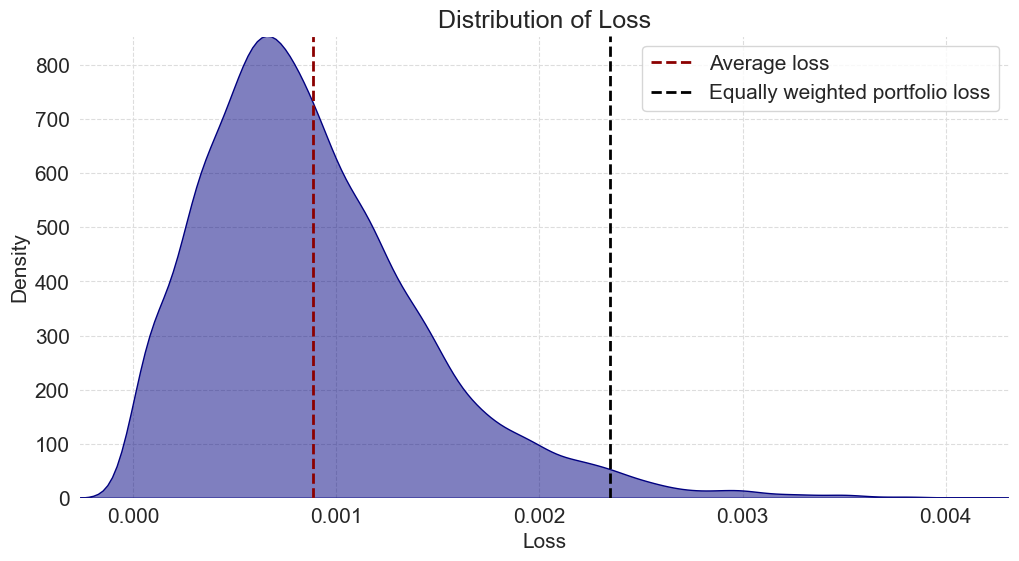

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(sim_loss, fill=True, ax=ax, color="navy", alpha=0.5)
ax.axvline(x=np.average(sim_loss), color="darkred", linestyle="--", label="Average loss")
ax.axvline(x=loss_eq_w, color="black", linestyle="--", label="Equally weighted portfolio loss", zorder=10)

ax.legend()
ax.set_title("Distribution of Loss")
ax.set_xlabel("Loss")
ax.set_ylabel("Density")

plt.tight_layout

plt.savefig("loss_distribution_example.png", dpi=300)

__Question 4__

In [56]:
# set random seed for reproducibility
np.random.seed(42)

# number of assets
num_assets = 20

# generate random beta coefficients between 0.5 and 1.5
betas = np.random.uniform(0.5, 1.5, num_assets)

# market parameters
rf = 0.02 / 12  # risk-free rate
market_return = 0.08 / 12  # expected market return
market_excess_return = market_return - rf
market_std = 0.15  / np.sqrt(12) # market standard deviation

# draw idiosyncratic std for each asset between 0.05 and 0.1
idiosyncratic_stds = np.random.uniform(0.05 / np.sqrt(12), 0.1 / np.sqrt(12), num_assets)

# draw alpha for each asset between -0.01 and 0.03
alphas = np.random.uniform(0.0 / 12, 0.0 / 12, num_assets)

# calculate vector of expected returns and covariance matrix
mu = alphas + rf + betas * market_excess_return
mu_excess = mu - rf
cov_mat = np.diag(idiosyncratic_stds**2) + np.outer(betas, betas) * market_std**2
corr_mat = cov_to_corr_matrix(cov_mat)
vols = np.sqrt(np.diag(cov_mat))

In [57]:
# calculate mvo portfolio with no alpha
w_mvo = calculate_mvo(mu, cov_mat, lam=5.0)

In [58]:
calculate_ceq(mu, cov_mat, w_eq, lam)

np.float64(0.002098617315437053)

In [59]:
calculate_ceq(mu, cov_mat, w_mvo, lam)

np.float64(0.002790631374630802)

In [60]:
num_sim = 10_000
sample_size = 120

sim_mu = stats.multivariate_normal.rvs(mean=mu, cov=cov_mat / sample_size, size=num_sim)
sim_mu_excess = sim_mu - rf
sim_cov_mat = stats.wishart.rvs(df = sample_size-1, scale = cov_mat / sample_size, size=num_sim)
sim_corr_mat = np.array([cov_to_corr_matrix(sim_cov_mat[i]) for i in range(num_sim)])

In [61]:
sim_w_mvo = np.array([calculate_mvo(sim_mu[i], sim_cov_mat[i], lam) for i in range(num_sim)])
sim_loss = np.array([calculate_loss(mu, cov_mat, sim_w_mvo[i], lam) for i in range(num_sim)])

loss_eq_w = calculate_loss(mu, cov_mat, np.repeat(1 / num_assets, num_assets), lam)

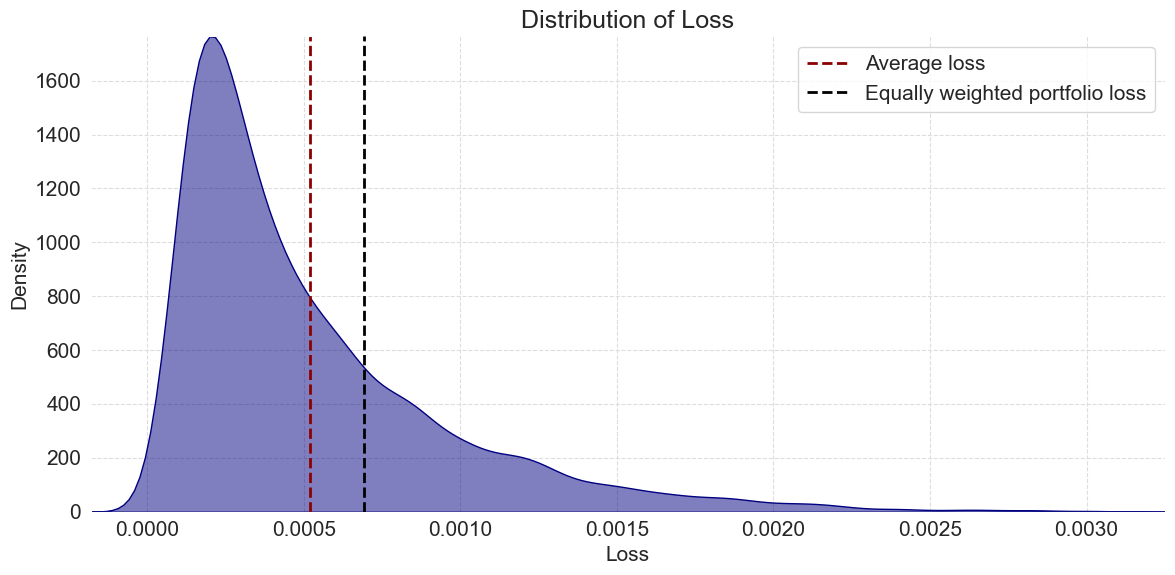

In [62]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(sim_loss, fill=True, ax=ax, color="navy", alpha=0.5)
ax.axvline(x=np.average(sim_loss), color="darkred", linestyle="--", label="Average loss")
ax.axvline(x=loss_eq_w, color="black", linestyle="--", label="Equally weighted portfolio loss", zorder=10)

ax.legend()
ax.set_title("Distribution of Loss")
ax.set_xlabel("Loss")
ax.set_ylabel("Density")

plt.tight_layout()

plt.savefig("loss_distribution_example.png", dpi=300)

__Question 5__

Play around with the different parameters / inputs.

## Problem 2: MVO with transaction costs

Assume that the investor initially holds an equally weighted portfolio, $\boldsymbol{w}_0$.

The investor considers the mean-variance efficient portfolio with $\lambda = 5$ (using true parameters) which accounts for transaction costs.

\begin{equation*}
    \boldsymbol{w}^* = \underset{\boldsymbol{w}}{\text{arg max }} \boldsymbol{w}^\top \boldsymbol{\mu} - \frac{\lambda}{2 } \boldsymbol{w}^\top \boldsymbol{\Sigma} \boldsymbol{w} + \tau \Vert \boldsymbol{w} - \boldsymbol{w}_0 \Vert_1
\end{equation*}

with the constraints

* $\boldsymbol{w} \geq 0$
* $\boldsymbol{w}^\top \boldsymbol{1} = 1$

Note that $\Vert \boldsymbol{w} - \boldsymbol{w}_0 \Vert_1$ is the L1 norm and $\tau$ is the constant proportional transaction costs.

__Question 1__

Implement the portfolio optimization as a python function.

__Question 2__

Assume $\tau = 0.005$ and


In [80]:
corr_mat = np.array([[1.0, 0.85, 0.5, 0.45],
                     [0.85, 1.0, 0.5, 0.45],
                     [0.5, 0.5, 1.0, 0.9],
                     [0.45, 0.45, 0.9, 1.0]])

vols = np.array([5.0, 5.0, 22.0, 22.0]) / 100.0

mu = np.array([3.2, 3.22, 8.4, 8.2]) / 100.0

cov_mat = corr_to_cov_matrix(corr_mat, vols)

Calculate the optimal portfolio with and without transaction costs. Comment on your findings.



### Solution

__Question 1__

In [90]:
# define function find the mean-variance optimal portfolio given the constraint
def calculate_mvo_with_tc(mu: np.ndarray, cov_mat: np.ndarray, lam: float = 5.0, tau: float = 0.0, w_init: np.ndarray = None, solver='OSQP', verbose: str = False):

    # define number of assets
    num_assets = len(mu)

    # initial weigts
    if w_init is None:
        w_init = np.repeat(1 / num_assets, num_assets)

    # define portfolio weights to optimize over
    w = cp.Variable(num_assets)

    # turn-over
    turnover = w - w_init

    # define mean-variance objective
    objective = w @ mu - 0.5*lam * cp.quad_form(w, cov_mat) - tau * cp.norm1(turnover)

    # define problem
    problem = cp.Problem(cp.Maximize(objective), constraints=[w>=0, cp.sum(w)==1])

    # solve problem
    problem.solve(solver=solver, verbose=verbose)

    return w.value

__Question 2__

In [96]:
tau = 0.005
lam = 5.0
num_assets = 4
init_w = np.repeat(1 / num_assets, num_assets)

w_mvo_no_tc = calculate_mvo_with_tc(mu, cov_mat, lam, 0.0, init_w, solver='OSQP', verbose=False)
w_mvo_w_tc = calculate_mvo_with_tc(mu, cov_mat, lam, tau, init_w, solver='OSQP')

In [93]:
print("Optimal weights without TC:", np.round(w_mvo_no_tc, 4))

Optimal weights without TC: [0.3507 0.4573 0.0914 0.1006]


In [94]:
print("Optimal weights with TC:", np.round(w_mvo_w_tc, 4))

Optimal weights with TC: [0.3242 0.4309 0.1209 0.124 ]


## Problem 3: Resampling

We would like to investigate a resampling approach similar to [Michaud (1989)](https://www.jstor.org/stable/4479185) but which directly uses the mean-variance trade-off

We use the data generating process:

In [107]:
# set random seed for reproducibility
np.random.seed(42)

# number of assets
num_assets = 20

# generate random beta coefficients between 0.5 and 1.5
betas = np.random.uniform(0.5, 1.5, num_assets)

# market parameters
rf = 0.02 / 12  # risk-free rate
market_return = 0.08 / 12  # expected market return
market_excess_return = market_return - rf
market_std = 0.15  / np.sqrt(12) # market standard deviation

# draw idiosyncratic std for each asset between 0.05 and 0.1
idiosyncratic_stds = np.random.uniform(0.05 / np.sqrt(12), 0.1 / np.sqrt(12), num_assets)

# draw alpha for each asset between -0.01 and 0.03
alphas = 0.0 # np.random.uniform(-0.01 / 12, 0.01 / 12, num_assets)

# calculate vector of expected returns and covariance matrix
mu = alphas + rf + betas * market_excess_return
mu_excess = mu - rf
cov_mat = np.diag(idiosyncratic_stds**2) + np.outer(betas, betas) * market_std**2
corr_mat = cov_to_corr_matrix(cov_mat)
vols = np.sqrt(np.diag(cov_mat))

__Question 1__

The investor considers the mean-variance efficient portfolio with $\lambda = 5$ (using true parameters) which accounts for transaction costs.

\begin{equation*}
    \boldsymbol{w}^* = \underset{\boldsymbol{w}}{\text{arg max }} \boldsymbol{w}^\top \boldsymbol{\mu} - \frac{\lambda}{2 } \boldsymbol{w}^\top \boldsymbol{\Sigma} \boldsymbol{w}
\end{equation*}

with the constraints

* $\boldsymbol{w} \geq 0$
* $\boldsymbol{w}^\top \boldsymbol{1} = 1$

Find the true optimal portfolio.

__Question 2__

Consider the resampling approach defined by the function


In [119]:
# define function find the mean-variance optimal portfolio given the constraint
def calculate_mvo_resampling(mu: np.ndarray, cov_mat: np.ndarray, lam: float = 5.0, sample_size: int = 120, num_resamples: int = 100, solver='OSQP'):

    # define number of assets
    num_assets = len(mu)

    # resampled weights
    weights_resample = []

    # define portfolio weights to optimize over
    w = cp.Variable(num_assets)

    for i in range(num_resamples):

        mu_resample = stats.multivariate_normal.rvs(mean=mu, cov=cov_mat / sample_size)
        cov_mat_resample = stats.wishart.rvs(df = sample_size-1, scale = cov_mat / sample_size)

        # define mean-variance objective
        objective = w @ mu_resample - 0.5 * lam * cp.quad_form(w, cov_mat_resample)

        # define problem
        problem = cp.Problem(cp.Maximize(objective), constraints=[w >= 0, cp.sum(w) == 1])

        # solve problem
        problem.solve(solver=solver)

        weights_resample.append(w.value)

    return np.average(np.array(weights_resample), axis=0)



__Question 3__

Simulate the mean-variance loss of the standard optimization approach and the resampling approach. Consider a sample size of 120. Use 1000 simulations. What do you observe?



### Solution

__Question 1__

In [114]:
# define function find the mean-variance optimal portfolio given the constraint
def calculate_mvo(mu: np.ndarray, cov_mat: np.ndarray, lam: float = 5.0, solver='OSQP'):
    # define number of assets
    num_assets = len(mu)

    # define portfolio weights to optimize over
    w = cp.Variable(num_assets)

    # define mean-variance objective
    objective = w @ mu - 0.5 * lam * cp.quad_form(w, cov_mat)

    # define problem
    problem = cp.Problem(cp.Maximize(objective), constraints=[w >= 0, cp.sum(w) == 1])

    # solve problem
    problem.solve(solver=solver)

    return w.value

# calculate mvo portfolio
w_mvo = calculate_mvo(mu, cov_mat, lam=5.0)

In [115]:
print("Optimal weights:", np.round(w_mvo, 4))

Optimal weights: [ 0.0233 -0.     -0.      0.      0.1298  0.0863  0.258   0.      0.
  0.      0.1579  0.     -0.      0.0579  0.0646  0.0759  0.0761  0.
  0.0015  0.0686]


__Question 2__

In [120]:
w_mvo_resampling = calculate_mvo_resampling(mu, cov_mat, lam=5.0, sample_size=120, num_resamples=100, solver='OSQP')

In [122]:
print("Optimal weights with resampling:", np.round(w_mvo_resampling, 4))

Optimal weights with resampling: [0.0751 0.0155 0.0305 0.0208 0.06   0.0916 0.0674 0.011  0.0365 0.0312
 0.1054 0.0062 0.0166 0.0789 0.1148 0.0706 0.0253 0.0141 0.0648 0.0639]


__Question 3__

In [123]:
num_sim = 1_000
sample_size = 120

sim_mu = stats.multivariate_normal.rvs(mean=mu, cov=cov_mat / sample_size, size=num_sim)
sim_mu_excess = sim_mu - rf
sim_cov_mat = stats.wishart.rvs(df = sample_size-1, scale = cov_mat / sample_size, size=num_sim)
sim_corr_mat = np.array([cov_to_corr_matrix(sim_cov_mat[i]) for i in range(num_sim)])

In [124]:
sim_w_mvo = np.array([calculate_mvo(sim_mu[i], sim_cov_mat[i], lam) for i in range(num_sim)])
sim_loss_mvo = np.array([calculate_loss(mu, cov_mat, sim_w_mvo[i], lam) for i in range(num_sim)])

sim_w_mvo_resampling = np.array([calculate_mvo_resampling(sim_mu[i], sim_cov_mat[i], lam) for i in range(num_sim)])
sim_loss_mvo_resampling = np.array([calculate_loss(mu, cov_mat, sim_w_mvo_resampling[i], lam) for i in range(num_sim)])

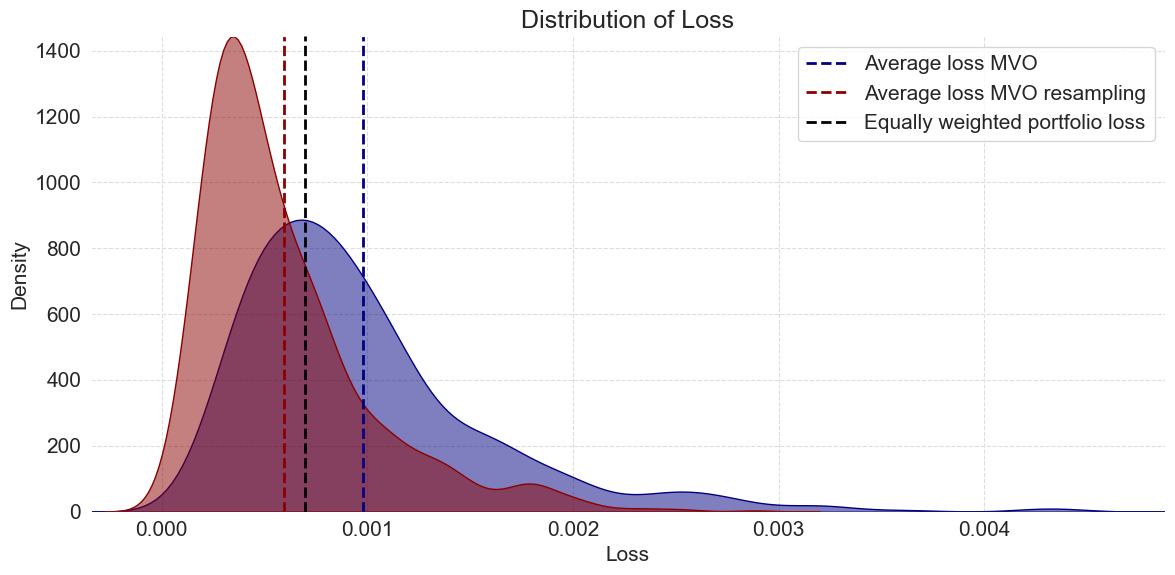

In [126]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(sim_loss_mvo, fill=True, ax=ax, color="navy", alpha=0.5)
ax.axvline(x=np.average(sim_loss_mvo), color="navy", linestyle="--", label="Average loss MVO")

sns.kdeplot(sim_loss_mvo_resampling, fill=True, ax=ax, color="darkred", alpha=0.5)
ax.axvline(x=np.average(sim_loss_mvo_resampling), color="darkred", linestyle="--", label="Average loss MVO resampling")

loss_eq_w = calculate_loss(mu, cov_mat, np.repeat(1 / num_assets, num_assets), lam)
ax.axvline(x=loss_eq_w, color="black", linestyle="--", label="Equally weighted portfolio loss", zorder=10)

ax.legend()
ax.set_title("Distribution of Loss")
ax.set_xlabel("Loss")
ax.set_ylabel("Density")

plt.tight_layout()


## Problem 4:  Portfolio characteristics

In this exercise, we will compare a value weighted versus an equally weighted strategy on the sector level.

__Question 1__

Obtain the Fama-French "12 industry portfolios" since 1999. Calculate a equally weighted return index and a value weighted return index.

Plot the time series of the index development.

__Question 2__

Plot a drawdown plot for the two indices.

__Question 3__

Calculate the arithmetic and geometric return.

__Question 4__

Calculate the ann. volatility. Also calculate the skewness and kurtosis.

__Question 5__

Which strategy would you prefer?


### Solution

__Question 1__

In [2]:
reader = FamaFrenchReader("12_Industry_Portfolios",
                          start=datetime.datetime(1999, 1, 1))
industry_port = reader.read()

# print description
industry_port['DESCR']

C:\Users\johan\AppData\Local\Temp\ipykernel_17392\3891303947.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industry_port = reader.read()
C:\Users\johan\AppData\Local\Temp\ipykernel_17392\3891303947.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industry_port = reader.read()
C:\Users\johan\AppData\Local\Temp\ipykernel_17392\3891303947.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industry_port = reader.read()
C:\Users\johan\AppData\Local\Temp\ipykernel_17392\3891303947.py:3: FutureWarning: The argument 'date_parse

'12 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202409 CRSP database. It contains value- and equal-weighted returns for 12 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2024 Eugene F. Fama and Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (309 rows x 12 cols)\n  1 : Average Equal Weighted Returns -- Monthly (309 rows x 12 cols)\n  2 : Average Value Weighted Returns -- Annual (25 rows x 12 cols)\n  3 : Average Equal Weighted Returns -- Annual (25 rows x 12 cols)\n  4 : Number of Firms in Portfolios (309 rows x 12 cols)\n  5 : Average Firm Size (309 rows x 12 cols)\n  6 : Sum of BE / Sum of ME (26 rows x 12 cols)\n  7 : Value-Weighted Average of BE/ME (26 rows x 12 cols)'

In [3]:
# get equally weighted
ind_eq_weighted = industry_port[1] / 100
ind_eq_weighted.columns = ind_eq_weighted.columns.str.strip()
#ind_eq_weighted.index = pd.to_datetime(ind_eq_weighted.index, format="%Y-%m")

# get market cap weighted 
ind_mc_weighted = industry_port[0] / 100
ind_mc_weighted.columns = ind_mc_weighted.columns.str.strip()
#ind_mc_weighted.index = pd.to_datetime(ind_mc_weighted.index, format="%Y%m")

# get number of companies in each sector
num_companies = industry_port[4]
num_companies.columns = num_companies.columns.str.strip()
#num_companies.index = pd.to_datetime(num_companies.index, format="%Y%m")

# get average firm size 
avg_firm_size = industry_port[5]
avg_firm_size.columns = avg_firm_size.columns.str.strip()
#avg_firm_size.index = pd.to_datetime(avg_firm_size.index, format="%Y%m")

# get sector market cap 
sector_mkt_cap  = num_companies * avg_firm_size
total_mkt_cap = sector_mkt_cap.sum(axis=1)

# get relative market cap
sector_mkt_cap_relative = sector_mkt_cap.divide(total_mkt_cap, axis="rows")

# calculate market return 
market_return = (sector_mkt_cap_relative * ind_mc_weighted).sum(axis="columns")

# calculate equal weighted return 
equal_weighted_return = (ind_mc_weighted / 12.0).sum(axis="columns")

# asset list
asset_list = ind_mc_weighted.columns

In [4]:
mkt_index = (1 + market_return).cumprod()
eq_index = (1 + equal_weighted_return).cumprod()

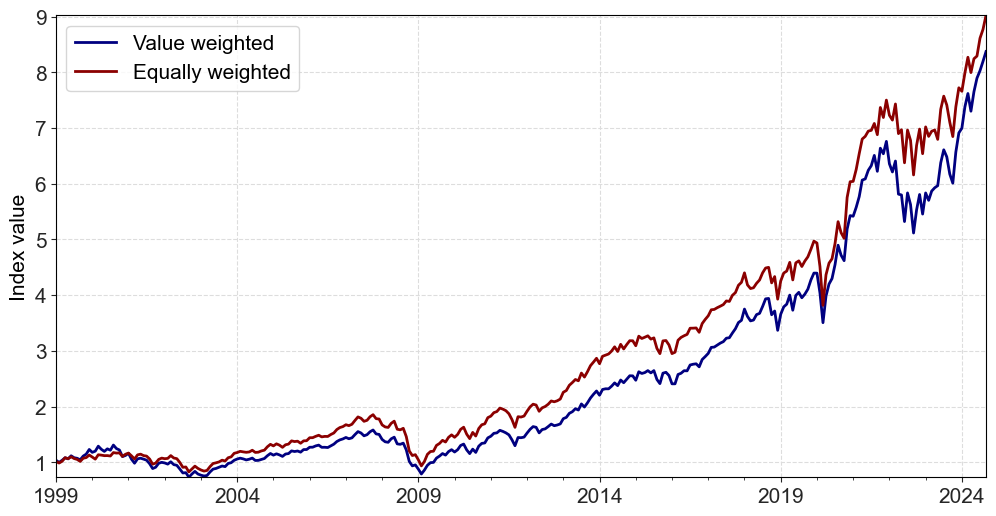

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))

mkt_index.plot(color="navy", label="Value weighted", xlabel="")
eq_index.plot(color="darkred", label="Equally weighted", xlabel="")
ax.set_ylabel("Index value")
ax.legend();

__Question 2__



In [6]:
dd_mkt = drawdown(mkt_index)[0]
dd_eq = drawdown(eq_index)[0]

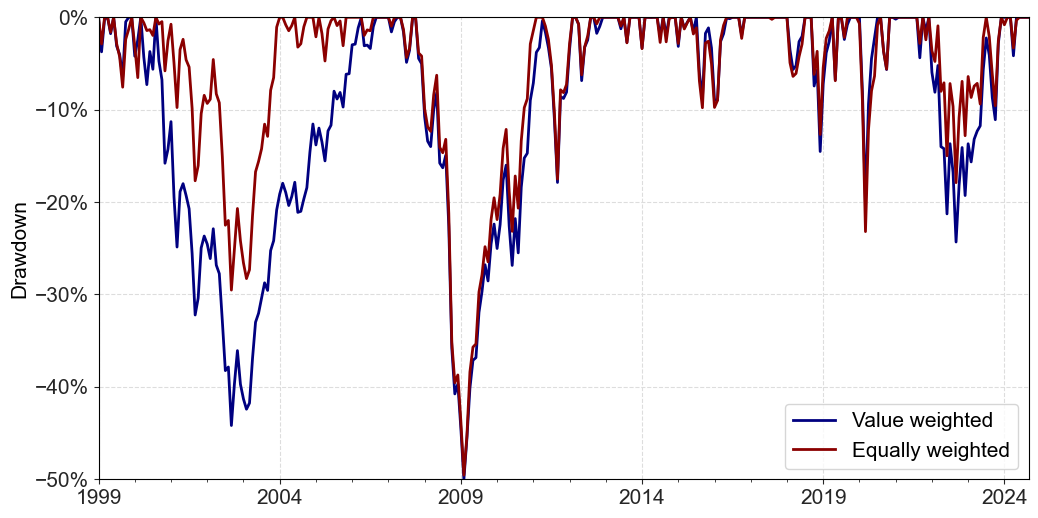

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

dd_mkt.plot(color="navy", label="Value weighted", xlabel="")
dd_eq.plot(color="darkred", label="Equally weighted", xlabel="")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_ylabel("Drawdown")
ax.legend();

__Question 3 and 4__

In [8]:
portfolio_descriptive = pd.DataFrame(columns=['Value weighted', 'Equally weighted'])

portfolio_descriptive.loc['Arithmetic Avg. return (ann.)', 'Value weighted'] = np.average(market_return) * 12
portfolio_descriptive.loc['Arithmetic Avg. return (ann.)', 'Equally weighted'] = np.average(equal_weighted_return) * 12

portfolio_descriptive.loc['Geometric return (ann.)', 'Value weighted'] = mkt_index.values[-1]**(12 / len(mkt_index)) - 1
portfolio_descriptive.loc['Geometric return (ann.)', 'Equally weighted'] = eq_index.values[-1]**(12 / len(eq_index)) - 1

portfolio_descriptive.loc['Volatility (ann.)', 'Value weighted'] = market_return.std() * np.sqrt(12)
portfolio_descriptive.loc['Volatility (ann.)', 'Equally weighted'] = equal_weighted_return.std() * np.sqrt(12)

portfolio_descriptive.loc['Kurtosis', 'Value weighted'] = market_return.kurt()
portfolio_descriptive.loc['Kurtosis', 'Equally weighted'] = equal_weighted_return.kurt()

portfolio_descriptive.loc['Skewness', 'Value weighted'] = market_return.skew()
portfolio_descriptive.loc['Skewness', 'Equally weighted'] = equal_weighted_return.skew()


In [9]:
portfolio_descriptive

,Value weighted,Equally weighted
Arithmetic Avg. return (ann.),0.09514,0.097286
Geometric return (ann.),0.086034,0.089197
Volatility (ann.),0.156464,0.15154
Kurtosis,0.766705,1.643938
Skewness,-0.490491,-0.432448


__Question 5__

?

## Problem 5: Satisfaction and portfolio optimization [Optional]

For simplicity, we consider the case where the linear returns follow a multivariate normal distribution 

$$
\mathbf{R} \sim MVN(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

Furthermore, assume that the investor's utility is given as a function of the wealth one year in the future $\Psi_1$ (exponential utility)

$$
U(\Psi_1) = -e^{-\frac{1}{\gamma} \Psi_1}, \; \gamma>0,
$$

the initial wealth is $\psi_0 = 1$, and that all assets has an initial price of one. 

__Question 1__

Derive the distribution of wealth $\Psi_1$ when assuming the allocation $\boldsymbol{\alpha}$ such that the wealth after one year is given by 

$$
\Psi_1 = \boldsymbol{\alpha}^\top (1  + \mathbf{R})
$$

__Question 2__

Since the wealth $\Psi_1$ will be normally distributed, then it is possible to show that 

$$
E[-e^{-\frac{1}{\gamma} \Psi_1}] = -e^{-\frac{1}{\gamma} E[\Psi_1] + \frac{1}{2 \gamma^2}Var[\Psi_1]}
$$

The Certainty-Equivalent (CE) is given by (should look familiar)

$$
\text{CE}(\boldsymbol{\alpha}) = U^{-1}(E[-e^{-\frac{1}{\gamma} \Psi_1}]) = - \gamma \ln (-E[-e^{-\frac{1}{\gamma} \Psi_1}]) =  E[\Psi_1] - \frac{1}{2 \gamma}Var[\Psi_1]
$$

Assume $\gamma = 1$. Plot level curves, the combinations of $E[\Psi_1]$ and $Var[\Psi_1]$ that give the same utility, when the asset universe consists of 10 assets with $\boldsymbol{\mu} = (0.01, 0.02, ...,  0.10)^\top$ and $\boldsymbol{\Sigma} = Diag((0.05^2, 0.06^2, ..., 0.14^2))$. At least plot the level curve on which the equally weighted portfolio is (note that the equally weighted portfolio is defined by $\alpha_i = \psi_0 / 10$ for $i=1, ..., 10$).

__Question 3__

Find the optimal allocation

$$
\boldsymbol{\alpha}^* = \arg \max_{\boldsymbol{\alpha}} \boldsymbol{\alpha}^\top (1 + \boldsymbol{\mu}) - \frac{1}{2 \gamma} \boldsymbol{\alpha}^\top \boldsymbol{\Sigma} \boldsymbol{\alpha}
$$

subject to $\boldsymbol{\alpha}^\top \boldsymbol{1} = \psi_0$. 

Define a function calculating the optimal allocation and calculate thereafter the optimal allocation. 

Add the level curve on which we find the optimal portfolio to the plot. 

__Question 4__

Add the mean-variance efficient frontier to the plot. What to you observe?


### Solution 

__Question 1__

$$
\Psi_1 \sim N(\boldsymbol{\alpha}^\top (1  + \boldsymbol{\mu}), \boldsymbol{\alpha}^\top \Sigma \boldsymbol{\alpha})
$$

__Question 2__

In [10]:
num_assets = 10
mu = np.arange(0.01, 0.101, 0.01)
vols = np.arange(0.05, 0.141, 0.01)
cov_mat = np.diag(vols)
gamma = 1
initial_wealth = 1 # _000_000

In [11]:
def calculate_port_variance(alpha: np.ndarray, cov_mat: np.ndarray): 
    
    return alpha @ cov_mat @ alpha 

def calculate_port_expected_value(alpha: np.ndarray, mu: np.ndarray): 
    
    return alpha @ (1 + mu)

def calculate_certainty_equivalent(alpha: np.ndarray,
                                   mu: np.ndarray,
                                   cov_mat: np.ndarray,
                                   gamma: float = 5.0): 
    
    exp_wealth = calculate_port_expected_value(alpha, mu)
    var_wealth = calculate_port_variance(alpha, cov_mat)
    
    return exp_wealth - 0.5 / gamma * var_wealth

In [12]:
w_eq = np.ones(num_assets) / num_assets
alpha_eq = w_eq * initial_wealth
eq_expected_wealth = calculate_port_expected_value(alpha_eq, mu)
eq_var = calculate_port_variance(alpha_eq, cov_mat)
eq_ce = calculate_certainty_equivalent(alpha_eq, mu, cov_mat, gamma=gamma)

In [13]:
eq_ce

1.0502500000000001

Solving for $E[\Psi_1]$ in $\text{CE}(\boldsymbol{\alpha}) = E[\Psi_1] - \frac{1}{2 \gamma}Var[\Psi_1]$ yields

$$
E[\Psi_1] = \text{CE}(\boldsymbol{\alpha}) +  \frac{1}{2 \gamma}Var[\Psi_1]
$$

which we can use to plot level curves

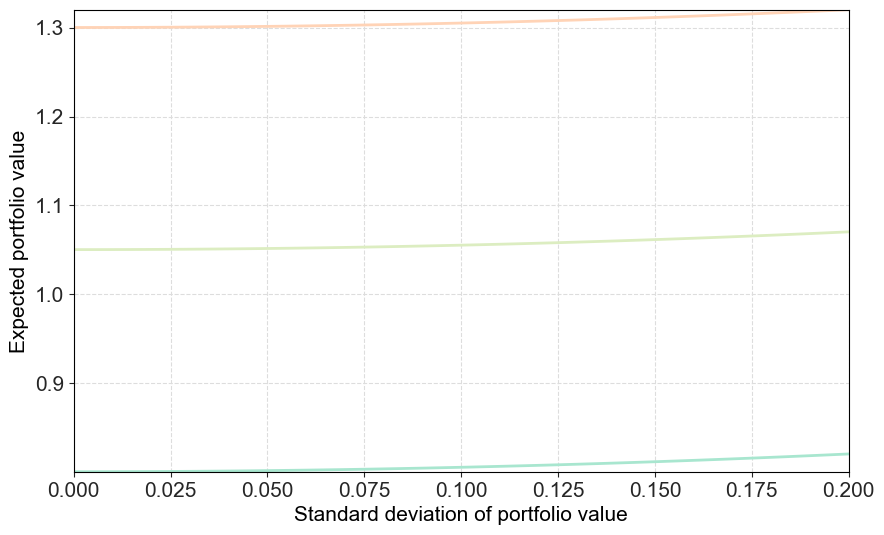

In [14]:
ce_levels = [-0.25 + eq_ce, eq_ce, eq_ce + 0.25]
std_values = np.linspace(0, 0.2, 100)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(std_values, ce_levels[0] + 0.5 / gamma * std_values**2)
ax.plot(std_values, ce_levels[1] + 0.5 / gamma * std_values**2)
ax.plot(std_values, ce_levels[2] + 0.5 / gamma * std_values**2)

ax.set(xlabel="Standard deviation of portfolio value", ylabel="Expected portfolio value");

__Question 3__

From the problem

$$
\boldsymbol{\alpha}^* = \arg \max_{\boldsymbol{\alpha}} \boldsymbol{\alpha}^\top (1 + \boldsymbol{\mu}) - \frac{1}{2 \gamma} \boldsymbol{\alpha}^\top \boldsymbol{\Sigma} \boldsymbol{\alpha}
$$

subject to $\boldsymbol{\alpha}^\top \boldsymbol{1} = \psi_0$, we can write the Lagrangian ($\lambda$ is here the Lagrange multiplier)

$$
\mathcal{L}(\boldsymbol{\alpha}, \lambda) = \boldsymbol{\alpha}^\top (1 + \boldsymbol{\mu}) - \frac{1}{2 \gamma} \boldsymbol{\alpha}^\top \boldsymbol{\Sigma} \boldsymbol{\alpha} + \lambda \left(\boldsymbol{\alpha}^\top \mathbf{1} - \psi_0 \right)
$$


The first order conditions read

$$
\begin{align}
\frac{\partial \mathcal{L}(\boldsymbol{\alpha}, \lambda)}{\partial \boldsymbol{\alpha}} &=  (1 + \boldsymbol{\mu}) - \frac{1}{\gamma} \boldsymbol{\Sigma} \boldsymbol{\alpha}  + \lambda \mathbf{1} = \mathbf{0} \\
\frac{\partial \mathcal{L}(\boldsymbol{\alpha}, \lambda)}{\partial \lambda} &= \boldsymbol{\alpha}^\top \mathbf{1} - \psi_0 = 0
\end{align}
$$

From the first condition, we obtain 

$$
\boldsymbol{\alpha}^* =  \gamma \boldsymbol{\Sigma}^{-1}(1 + \boldsymbol{\mu})  + \gamma \boldsymbol{\Sigma}^{-1} \lambda \mathbf{1}
$$

Then, we obtain 

$$
\mathbf{1}^\top \boldsymbol{\alpha}^* = \gamma  \mathbf{1}^\top \boldsymbol{\Sigma}^{-1}(1 + \boldsymbol{\mu})  + \gamma \mathbf{1}^\top \boldsymbol{\Sigma}^{-1}  \mathbf{1} \lambda = \psi_0
$$

Thus, 

$$
\lambda^* = \frac{\psi_0 -  \gamma  \mathbf{1}^\top \boldsymbol{\Sigma}^{-1}(1 + \boldsymbol{\mu})}{\gamma \mathbf{1}^\top \boldsymbol{\Sigma}^{-1}  \mathbf{1}}
$$

Inserting into the optimality condition for $\boldsymbol{\alpha}$

$$
\boldsymbol{\alpha}^* =  \gamma \boldsymbol{\Sigma}^{-1}(1 + \boldsymbol{\mu})  + \gamma \boldsymbol{\Sigma}^{-1} \lambda \mathbf{1} = \gamma \boldsymbol{\Sigma}^{-1}(1 + \boldsymbol{\mu})  + \frac{\psi_0 -  \gamma  \mathbf{1}^\top \boldsymbol{\Sigma}^{-1}(1 + \boldsymbol{\mu})}{ \mathbf{1}^\top \boldsymbol{\Sigma}^{-1}  \mathbf{1}} \boldsymbol{\Sigma}^{-1}  \mathbf{1}
$$

__Note: Alternatively, one could just find the numerical solution__

In [15]:
def calculate_optimal_alpha(mu: np.ndarray, cov_mat: np.ndarray, initial_wealth, gamma: float = 5.0): 
    
    cov_mat_inv = np.linalg.inv(cov_mat)
    one_vec = np.ones_like(mu)
    
    part1 = gamma*cov_mat_inv @ (1 + mu)
    
    part2 = (initial_wealth - one_vec @ part1)  * cov_mat_inv @ one_vec  / (one_vec @ cov_mat_inv @ one_vec)
    
    return part1 + part2

In [16]:
alpha_opt = calculate_optimal_alpha(mu, cov_mat, initial_wealth, gamma)
opt_expected_wealth = calculate_port_expected_value(alpha_opt, mu)
opt_var = calculate_port_variance(alpha_opt, cov_mat)
opt_ce = calculate_certainty_equivalent(alpha_opt, mu, cov_mat, gamma=gamma)

In [17]:
alpha_opt

array([-0.54079381, -0.28399484, -0.10056701,  0.03700387,  0.14400344,
        0.2296031 ,  0.29963918,  0.35800258,  0.407387  ,  0.4497165 ])

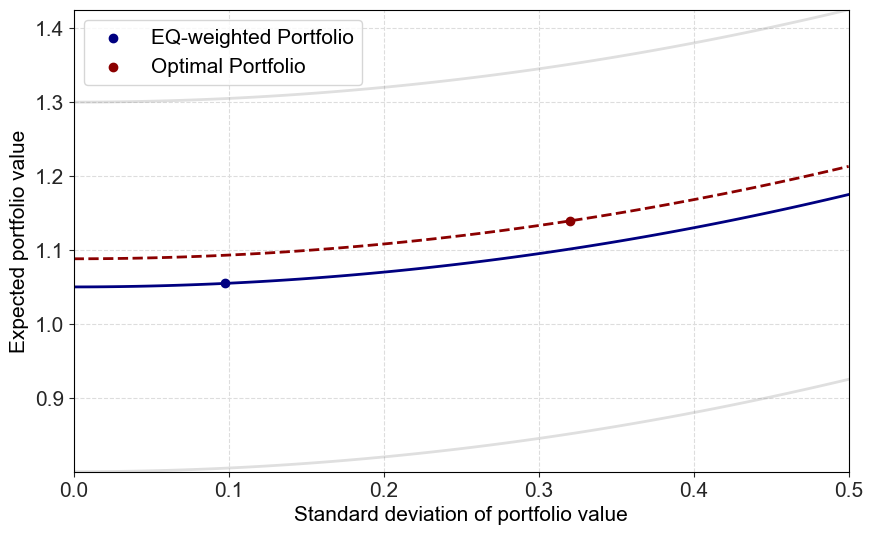

In [18]:
ce_levels = [-0.25 + eq_ce, eq_ce, eq_ce + 0.25]
std_values = np.linspace(0, 0.5, 100)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(std_values, ce_levels[0] + 0.5 / gamma * std_values**2, color="gray", alpha=0.25)

ax.scatter(np.sqrt(eq_var), eq_expected_wealth, color="navy", label="EQ-weighted Portfolio")
ax.plot(std_values, ce_levels[1] + 0.5 / gamma * std_values**2, color="navy")

ax.plot(std_values, ce_levels[2] + 0.5 / gamma * std_values**2, color="gray", alpha=0.25)

ax.scatter(np.sqrt(opt_var), opt_expected_wealth, color="darkred", label="Optimal Portfolio")
ax.plot(std_values, opt_ce + 0.5 / gamma * std_values**2, color="darkred", linestyle="--")

ax.set(xlabel="Standard deviation of portfolio value", ylabel="Expected portfolio value");

ax.legend();

__Question 4__

Apply the formula for mean-variance optimal portfolio from the lectures. 

In [19]:
def calculate_mvo_portfolio(mu: np.ndarray, cov_mat: np.ndarray, target: float, initial_wealth):
    
    b = np.r_[np.zeros_like(mu), target, initial_wealth]
    A = np.vstack((np.c_[2*cov_mat, (1 + mu), np.ones_like(mu)], 
                  np.r_[(1 + mu), 0, 0], np.r_[np.ones_like(mu), 0, 0]))
    
    alpha_opt = np.linalg.inv(A) @ b
    
    return alpha_opt[:len(mu)]

In [20]:
targets = np.linspace(initial_wealth, initial_wealth*(1 + 0.2), 50)

mean_var_eff_alpha = np.array([calculate_mvo_portfolio(mu, cov_mat, t, initial_wealth)  for  t in targets])

In [21]:
std_eff = np.sqrt(np.apply_along_axis(calculate_port_variance, 1, mean_var_eff_alpha, (cov_mat)))
expectation_eff = np.apply_along_axis(calculate_port_expected_value, 1, mean_var_eff_alpha, (mu))

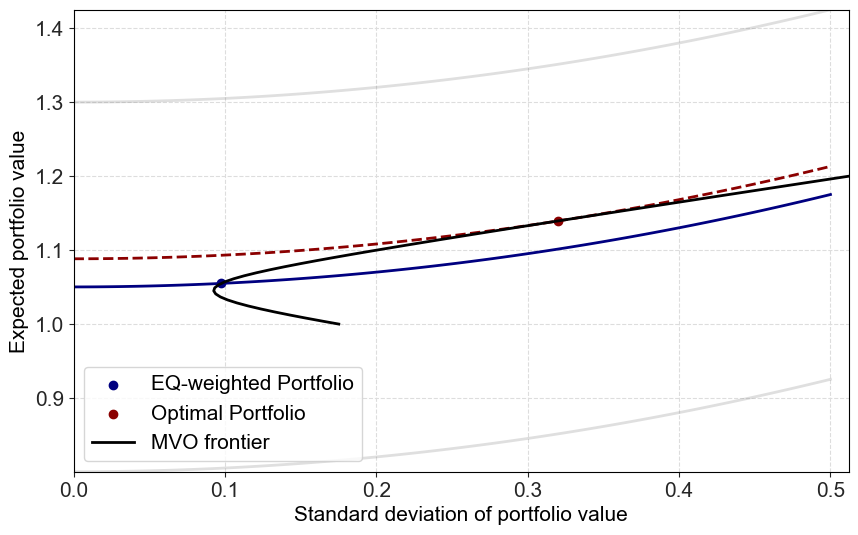

In [22]:
ce_levels = [-0.25 + eq_ce, eq_ce, eq_ce + 0.25]
std_values = np.linspace(0, 0.5, 100)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(std_values, ce_levels[0] + 0.5 / gamma * std_values**2, color="gray", alpha=0.25)

ax.scatter(np.sqrt(eq_var), eq_expected_wealth, color="navy", label="EQ-weighted Portfolio")
ax.plot(std_values, ce_levels[1] + 0.5 / gamma * std_values**2, color="navy")

ax.plot(std_values, ce_levels[2] + 0.5 / gamma * std_values**2, color="gray", alpha=0.25)

ax.scatter(np.sqrt(opt_var), opt_expected_wealth, color="darkred", label="Optimal Portfolio")
ax.plot(std_values, opt_ce + 0.5 / gamma * std_values**2, color="darkred", linestyle="--")

ax.plot(std_eff, expectation_eff, color="black", label="MVO frontier")

ax.set(xlabel="Standard deviation of portfolio value", ylabel="Expected portfolio value");

#ax.set_ylim([0.75, 1.25])
ax.legend();

## Problem 6:  Long-term risk and portfolio optimization

Again, consider the Fama-French "12 industry portfolios" since 1999.

__Question 1__

We may assume that log-returns follows a multivariate normal distribution. 

$$
\log \mathbf{P}_{t+1} - \log \mathbf{P}_t \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

Estimate the expected log-return and the covariance matrix of log-returns. 

__Question 2__

Based on the above estimates, simulate the asset prices 5-years into the future. Consider 10,000 paths and yearly time steps. 

Calculate the return of an equally weighted constant mix portfolio. Plot a fan chart of the development of the index value of the constant mix. Compare with a buy and hold portfolio. 

__Question 3__

Calculate the mean, variance and CVaR at the 5-year horizon. 

__Question 4__

Select the constant mix portfolio that minimizes the 5Y CVaR(5%) for a return target of e.g. $50\%$.  

__Question 5__

Suggest and apply a resampling approach. 

__Question 6__

Do we obtain similar results with a buy and hold strategy?

### Solution 

__Question 1__

As previously seen, we can simply use `pandas-datareader`. 

In [23]:
reader = FamaFrenchReader("12_Industry_Portfolios", start=datetime.datetime(1999, 1, 1))
industry_port = reader.read()

# print description
industry_port['DESCR']

C:\Users\johan\AppData\Local\Temp\ipykernel_17392\4063279770.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industry_port = reader.read()
C:\Users\johan\AppData\Local\Temp\ipykernel_17392\4063279770.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industry_port = reader.read()
C:\Users\johan\AppData\Local\Temp\ipykernel_17392\4063279770.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industry_port = reader.read()
C:\Users\johan\AppData\Local\Temp\ipykernel_17392\4063279770.py:2: FutureWarning: The argument 'date_parse

'12 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202409 CRSP database. It contains value- and equal-weighted returns for 12 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2024 Eugene F. Fama and Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (309 rows x 12 cols)\n  1 : Average Equal Weighted Returns -- Monthly (309 rows x 12 cols)\n  2 : Average Value Weighted Returns -- Annual (25 rows x 12 cols)\n  3 : Average Equal Weighted Returns -- Annual (25 rows x 12 cols)\n  4 : Number of Firms in Portfolios (309 rows x 12 cols)\n  5 : Average Firm Size (309 rows x 12 cols)\n  6 : Sum of BE / Sum of ME (26 rows x 12 cols)\n  7 : Value-Weighted Average of BE/ME (26 rows x 12 cols)'

In [24]:
# get equally weighted
ind_eq_weighted = industry_port[1] / 100
ind_eq_weighted.columns = ind_eq_weighted.columns.str.strip()


# get market cap weighted 
ind_mc_weighted = industry_port[0] / 100
ind_mc_weighted.columns = ind_mc_weighted.columns.str.strip()

asset_list = ind_mc_weighted.columns

In [25]:
"""
Calculate log returns
"""

log_returns = np.log(1+ind_mc_weighted)

In [26]:
mean_log_returns = log_returns.mean()
mean_log_returns

NoDur    0.006591
Durbl    0.005947
Manuf    0.008257
Enrgy    0.006938
Chems    0.006459
BusEq    0.007902
Telcm    0.002557
Utils    0.006920
Shops    0.007966
Hlth     0.006693
Money    0.005704
Other    0.005506
dtype: float64

In [27]:
cov_mat_log_returns = log_returns.cov()
cov_mat_log_returns

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
NoDur,0.001358,0.001640,0.001493,0.001358,0.001244,0.001084,0.001200,0.000989,0.001102,0.000948,0.001488,0.001322
Durbl,0.001640,0.008024,0.003868,0.002767,0.002280,0.003818,0.002572,0.001290,0.002924,0.001610,0.003481,0.003490
Manuf,0.001493,0.003868,0.003415,0.002721,0.002064,0.002923,0.002176,0.001270,0.002098,0.001421,0.002743,0.002793
Enrgy,0.001358,0.002767,0.002721,0.005084,0.001714,0.001808,0.001786,0.001517,0.001393,0.001113,0.002367,0.002191
Chems,0.001244,0.002280,0.002064,0.001714,0.001849,0.001554,0.001373,0.001024,0.001360,0.001113,0.001821,0.001782
BusEq,0.001084,0.003818,0.002923,0.001808,0.001554,0.004912,0.002541,0.000776,0.002271,0.001432,0.002242,0.002743
Telcm,0.001200,0.002572,0.002176,0.001786,0.001373,0.002541,0.002839,0.000902,0.001665,0.001185,0.002017,0.002053
Utils,0.000989,0.001290,0.001270,0.001517,0.001024,0.000776,0.000902,0.001887,0.000770,0.000786,0.001115,0.001101
Shops,0.001102,0.002924,0.002098,0.001393,0.001360,0.002271,0.001665,0.000770,0.002128,0.001103,0.001935,0.001962
Hlth,0.000948,0.001610,0.001421,0.001113,0.001113,0.001432,0.001185,0.000786,0.001103,0.001719,0.001446,0.001368


In [28]:
corr_mat_log_returns = cov_to_corr_matrix(cov_mat_log_returns)

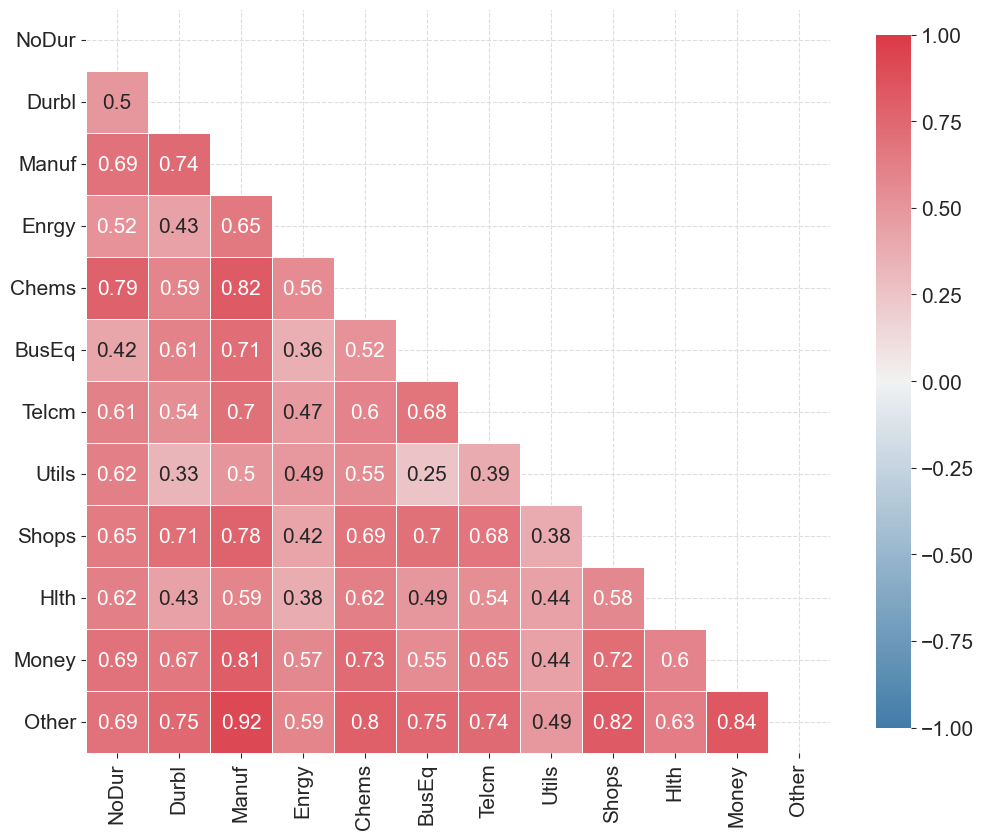

In [29]:
fig, ax = plt.subplots(figsize=(12, 12))
correlation_plot(corr_mat_log_returns, names=asset_list, include_values=True, ax=ax)

__Question 2__

We can simulate log-returns using a multivariate normal distribution and aggregate across time. 

In [30]:
def simulate_asset_prices(mu: np.ndarray, cov_mat: np.ndarray,
                          horizon: float, dt: float, num_sim: int,
                          transform_input: bool=False) -> np.ndarray:
    
    """
    Simulates asset prices
    
    Parameters
    ----------
    mu: 
        Expected log-returns. 
    cov_mat: 
        Covariance matrix of log-returns. 
    horizon: 
        Simulation horizon in years. 
    dt: 
        Time step. 
    num_sim: 
        Number of simulations. 
    transform_input: 
        Boolean indicating whether to transform mu and cov_mat to time_step. 
    
    
    Returns
    -------
    np.ndarray
        Simulated asset prices  [num sim x num time steps x num_assets]. 
    
    
    """
    
    if transform_input:
        mu = mu * dt
        cov_mat = cov_mat * dt
        
    num_assets = len(mu)
    
    num_periods = int(horizon / dt)
    
    # allocate memory
    asset_prices = np.ones((num_sim, 1 + num_periods, num_assets))
    
    # simulate returns
    log_ret = np.random.multivariate_normal(mu, cov_mat,
                                            size=(num_sim, num_periods))
    
    # transform returns to asset prices
    asset_prices[:, 1:, :] = np.exp(np.cumsum(log_ret, axis=1))
    
    return asset_prices

In [31]:
"""
Simulate asset prices
"""

num_sim = 5000
dt = 1.0 # 1.0/12.0
horizon = 5.0
mu = mean_log_returns.values * 12.0
cov_mat = cov_mat_log_returns * 12.0

time_points = np.arange(0.0, horizon + 0.01, dt)
asset_prices  = simulate_asset_prices(mu, cov_mat, horizon, dt, num_sim)

The value of a buy and hold strategy is simply given by (assuming the initial value of the assets and portfolios are equal to 1)

$$
V_T = \mathbf{w}^\top \mathbf{P}_T
$$

where $V_T$ denotes the portfolio value, $\mathbf{P}_T$ denotes the vector of asset prices and $\mathbf{w}$ denote the initial portfolio weights. 

In [32]:
"""
Buy and hold strategy 
"""

port_w = np.ones(len(mu)) / len(mu)

buy_and_hold_index = asset_prices @ port_w

In [33]:
asset_prices.shape

(5000, 6, 12)

In [34]:
buy_and_hold_index.shape

(5000, 6)

The value of the constant mix strategy 

$$
V_T = \prod_{t = 1}^T (1 + \mathbf{w}^\top \mathbf{R}_t)
$$

where $\mathbf{R}_t$ is the period return of the assets. 

In [35]:
"""
Constant mix porfolio (monthly rebalancing)
"""

def calculate_period_returns(index: np.ndarray) -> np.ndarray:
    
    """
    Calculates period returns
    
    Paramters
    ---------
    index: 
        Index values [num sim x num time steps x num_assets]. 
        
    Returns
    -------
    np.ndarray
        Period returns. 
    
    """
    
    # get size of matrix
    n = index.shape[1]

    # get matrix not lagged
    new_mat = index[:, 1:n]
    # get matrix lagged
    old_mat = index[:, 0:n-1]
    # get 1 + return
    periodtr = new_mat / old_mat
    
    return periodtr - 1
    

def calculate_constant_mix_index(index: np.ndarray, weights: np.ndarray) -> np.ndarray:
    
    """
    Calculates cum. return index of a constant mix strategy. 
    
    Parameters
    ----------
    index: 
        Index values  [num sim x num time steps x num_assets]. 
    weights: 
        Portfolio weights. 
        
    
    Returns
    -------
    np.ndarray
        Cum. return index [num sim x num time steps]. 
    
    """
    
    port_index = np.ones((index.shape[0], index.shape[1]))
    
    # calculate period returns on assets
    per_ret = calculate_period_returns(index)
    
    # calculate port. period return
    port_per_ret = per_ret @ weights
    
    # calculate port. index
    port_index[:, 1:] = np.cumprod(1 + port_per_ret, axis=1)
    
    return port_index
    

constant_mix_index = calculate_constant_mix_index(asset_prices, port_w)

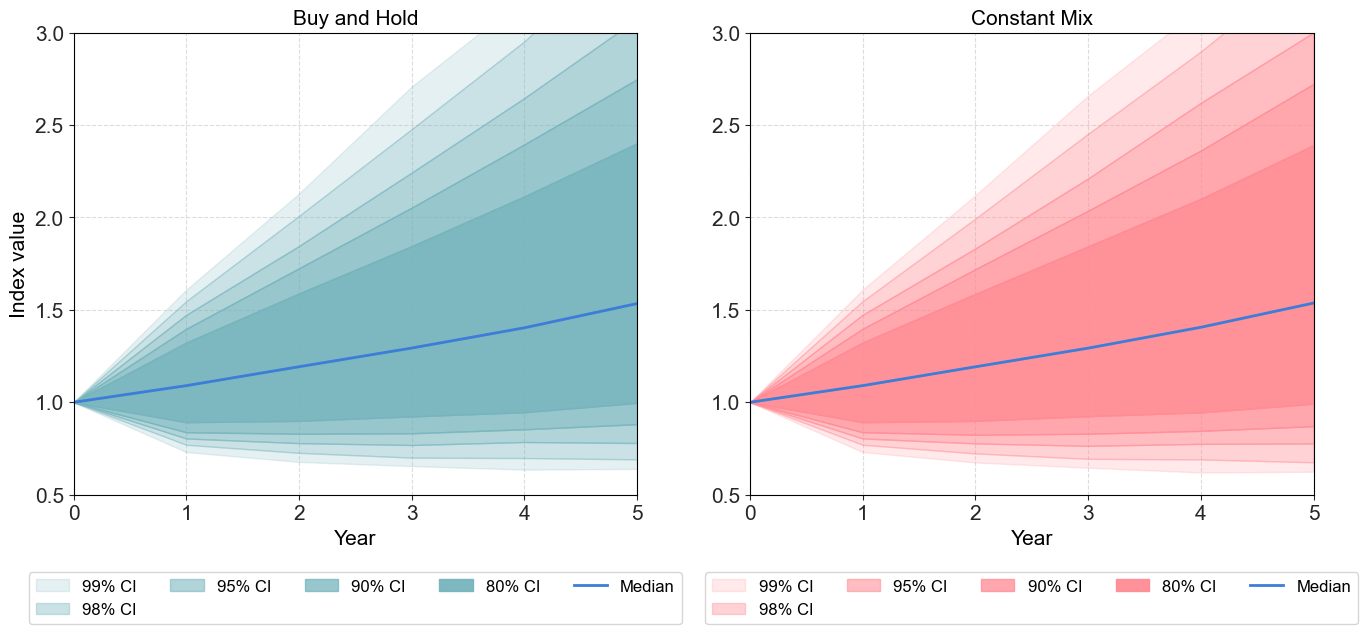

In [36]:
# calculate percentiles
percentiles_buy_and_hold = np.percentile(buy_and_hold_index,
                                         [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)
percentiles_constant_mix = np.percentile(constant_mix_index, 
                                         [0.5, 1.0, 2.5, 5, 10, 50, 90, 95, 97.5, 99.0, 99.5],
                                         axis=0)

"""
Plot fan chart
"""

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fan_chart(time_points,
          percentiles_buy_and_hold,
          color=default_colors['cyan'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[0])

ax[0].set_xlabel("Year", size=15)
ax[0].set_ylabel("Index value", size=15)
ax[0].set_title("Buy and Hold", size=15)
ax[0].set_ylim([0.5, 3.0])
ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

fan_chart(time_points,
          percentiles_constant_mix,
          color=default_colors['red'],
          color_median=default_colors['dark_blue'],
          labels=['99% CI', '98% CI', '95% CI', '90% CI', '80% CI', 'Median'],
          ax=ax[1])

ax[1].set_xlabel("Year", size=15)
ax[1].set_title("Constant Mix", size=15)
ax[1].set_ylim([0.5, 3.0])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=12);

__Question 3__

In [37]:
np.std(buy_and_hold_index[:, -1])

0.5894673227997073

In [38]:
np.std(constant_mix_index[:, -1])

0.57762083968977

In [39]:
np.mean(buy_and_hold_index[:, -1])

1.6361743677305662

In [40]:
np.mean(constant_mix_index[:, -1])

1.6304987550788166

In [41]:
buy_and_hold_index[:, -1]

array([1.42423239, 1.90793431, 1.73194825, ..., 0.97387319, 1.96172092,
       1.43971577])

In [42]:
value_at_risk = np.percentile(buy_and_hold_index[:, -1], 5)
cond_value_at_risk = np.mean(buy_and_hold_index[:, -1][buy_and_hold_index[:, -1] <= value_at_risk])
cond_value_at_risk

0.7633800612686231

In [43]:
value_at_risk = np.percentile(constant_mix_index[:, -1], 5)
cond_value_at_risk = np.mean(constant_mix_index[:, -1][constant_mix_index[:, -1] <= value_at_risk])
cond_value_at_risk

0.7546822830937383

In [44]:
np.mean(calculate_constant_mix_index(asset_prices, port_w)[:, -1])

1.6304987550788166

__Question 4__

We can apply the techniques from the exercises in week 5.  

We need to take into account the difference between how the cum. return index of the buy and hold and constant mix portfolio is calculated. 

_Note: See [Rockafeller and Uryasev (2000)](https://www.ise.ufl.edu/uryasev/files/2011/11/CVaR1_JOR.pdf) for a more efficient approach using convex optimization in the buy-and-hold case_

In [45]:
def objective_function(x, index, beta):

    constant_mix_index = calculate_constant_mix_index(index, x)[:, -1]

    return -calculate_conditional_value_at_risk(constant_mix_index, p = 1.0 - beta)

# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x}

# alternatively use 
bounds = [(0.0, 1.0)] * 12 #+ [(None, None)]


def target_return_constraint(x, target, asset_prices):

    return np.mean(calculate_constant_mix_index(asset_prices, x)[:, -1]) - target

port_weights = list()
targets = [1.4, 1.45, 1.5, 1.55, 1.6, 1.65, 1.7]
for target in targets:
    
    print(target)
    
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: target_return_constraint(x, target, asset_prices)}


    x0 = np.r_[np.ones(12) / 12.0]
    res = optimize.minimize(objective_function, x0=x0, args=(asset_prices, 0.95),
                            method='SLSQP',
                            constraints=[sum_to_one_cons,  target_cons], 
                            options={'ftol': 1e-9, 'disp': True}, bounds=bounds)

    port_weights.append(res.x) #[:-1])
    
    
port_weights = np.array(port_weights)

1.4
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.695509009399426
            Iterations: 15
            Function evaluations: 214
            Gradient evaluations: 15
1.45
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7649013343315856
            Iterations: 16
            Function evaluations: 227
            Gradient evaluations: 16
1.5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.823151460744666
            Iterations: 16
            Function evaluations: 217
            Gradient evaluations: 16
1.55
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.8682293385179307
            Iterations: 14
            Function evaluations: 201
            Gradient evaluations: 14
1.6
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.8968738050081847
            Iterations

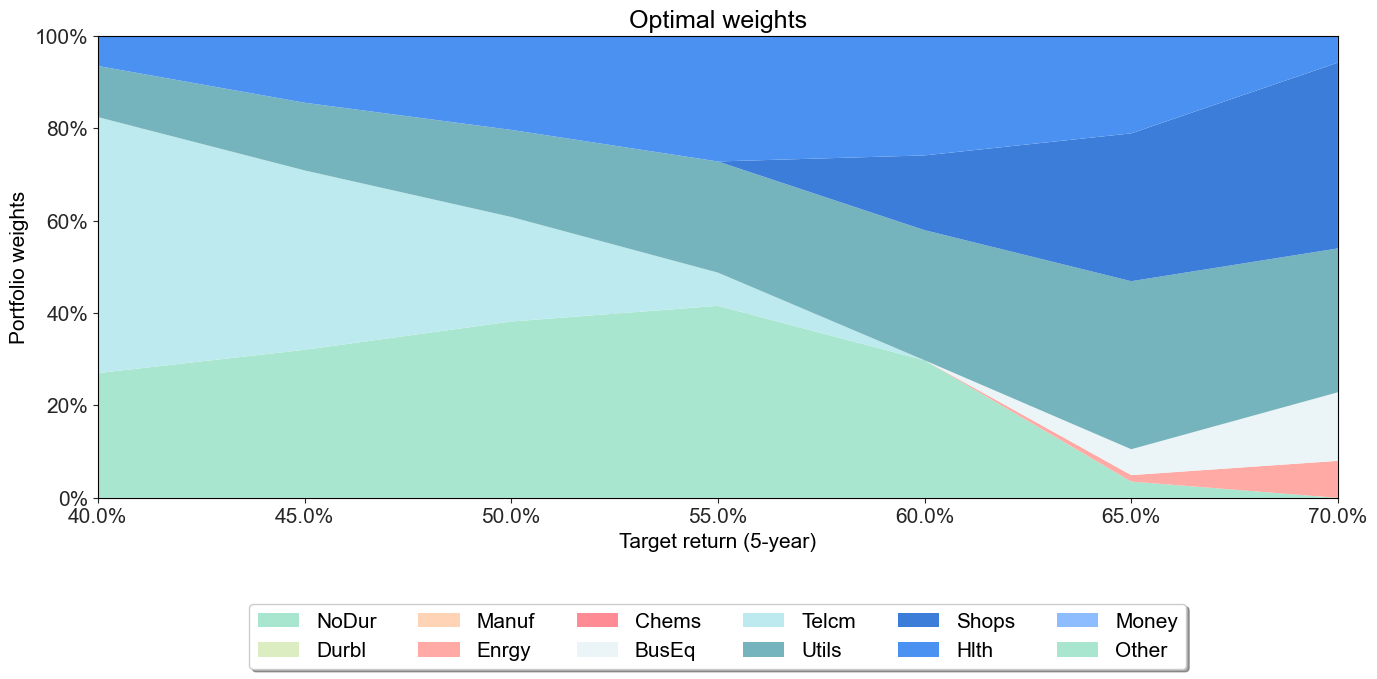

In [46]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(np.array(targets) - 1.0, port_weights.T, labels=asset_list);
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=6);
ax.set_xlabel("Target return (5-year)")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights");

In [47]:
for i in range(len(targets)):
    
    index_vals = calculate_constant_mix_index(asset_prices, port_weights[i])[:, -1]
    value_at_risk = np.percentile(index_vals, 5)
    cond_value_at_risk = np.mean(index_vals[index_vals <= value_at_risk])
    print("CVaR(5%) for target = {}: ".format(targets[i]))
    print(cond_value_at_risk)
    print("\n")

CVaR(5%) for target = 1.4: 
0.695509009399426


CVaR(5%) for target = 1.45: 
0.7649013343315856


CVaR(5%) for target = 1.5: 
0.8231514607446658


CVaR(5%) for target = 1.55: 
0.8682293385179307


CVaR(5%) for target = 1.6: 
0.8968738050081847


CVaR(5%) for target = 1.65: 
0.889415394370722


CVaR(5%) for target = 1.7: 
0.8532168103736884




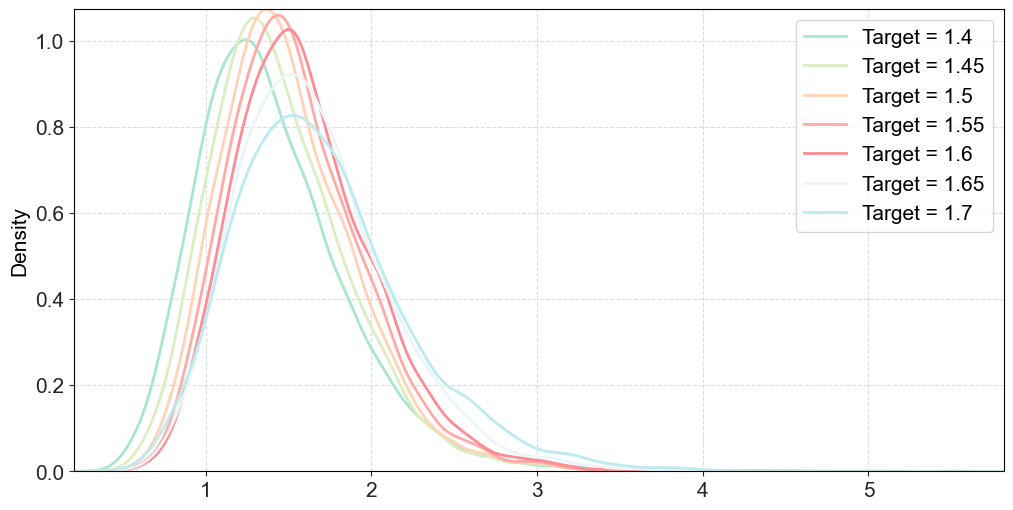

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))    

for i in range(len(targets)):
    sns.kdeplot(calculate_constant_mix_index(asset_prices, port_weights[i])[:, -1],
                label="Target = {}".format(targets[i]))
    
ax.legend();

__Question 5__

We simply resample a number of paths from the simulated asset prices and perform the portfolio optimization again. Repeat this a large number of times. The average is the optimal allocations. 

In [49]:
targets = [1.4, 1.45, 1.5, 1.55, 1.6, 1.65]

num_resamples = 50
size_resample = 500
optimal_port_resampled_weights = np.zeros((len(targets), 12))
for i in range(num_resamples): 
    print(i)
    asset_prices_sim = asset_prices[np.random.randint(0, num_sim,
                                                      size=size_resample), :, :]
    
    opt_port_w_sim = []
    for target in targets:

        #print(target)

        # define constraint 
        target_cons = {'type': 'eq',
                       'fun' : lambda x: target_return_constraint(x, target, asset_prices_sim)}


        x0 = np.r_[np.ones(12) / 12.0]
        res = optimize.minimize(objective_function, x0=x0, args=(asset_prices_sim, 0.95),
                                method='SLSQP',
                                constraints=[sum_to_one_cons,  target_cons], 
                                options={'ftol': 1e-9, 'disp': False}, bounds=bounds)

        opt_port_w_sim.append(res.x)


    optimal_port_resampled_weights += np.array(opt_port_w_sim) / num_resamples
    
optimal_port_resampled_weights = np.array(optimal_port_resampled_weights)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


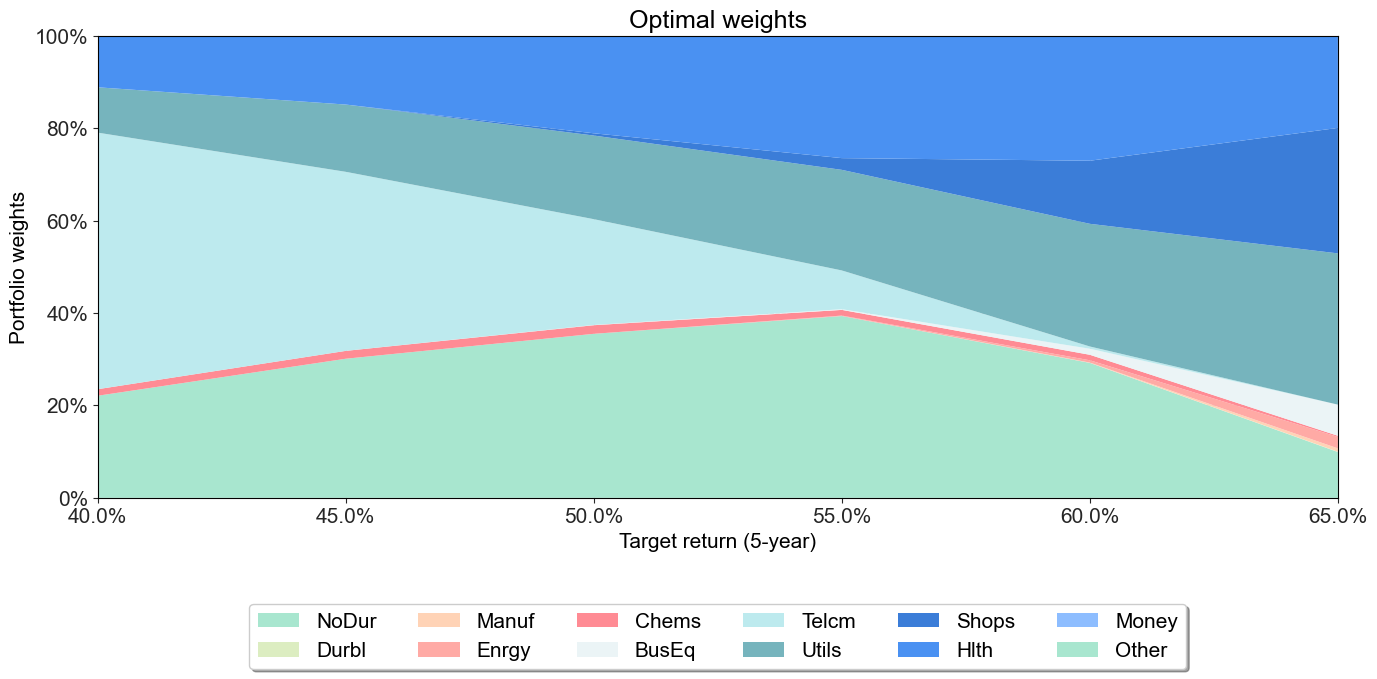

In [50]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(np.array(targets) - 1.0, optimal_port_resampled_weights.T, labels=asset_list);
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=6);
ax.set_xlabel("Target return (5-year)")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights");

In [51]:
for i in range(len(targets)):
    
    index_vals = calculate_constant_mix_index(asset_prices, optimal_port_resampled_weights[i])[:, -1]
    value_at_risk = np.percentile(index_vals, 5)
    cond_value_at_risk = np.mean(index_vals[index_vals <= value_at_risk])
    print("CVaR(5%) for target = {}: ".format(targets[i]))
    print(cond_value_at_risk)
    print("\n")

CVaR(5%) for target = 1.4: 
0.695258609116731


CVaR(5%) for target = 1.45: 
0.7647010093326764


CVaR(5%) for target = 1.5: 
0.8220567267123079


CVaR(5%) for target = 1.55: 
0.866556643745582


CVaR(5%) for target = 1.6: 
0.8940523936499166


CVaR(5%) for target = 1.65: 
0.8884423866864042




__Question 6__

In [52]:
def objective_function_buy_and_hold(w, index, beta):

    buy_and_hold_index = (index @ w)[:, -1]

    return -calculate_conditional_value_at_risk(buy_and_hold_index, p = 1.0 - beta)

port_weights = list()
targets = [1.4, 1.45, 1.5, 1.55, 1.6, 1.65]

num_resamples = 50
size_resample = 500
optimal_port_resampled_weights_buy_and_hold = np.zeros((len(targets), 12))
for i in range(num_resamples): 
    print(i)
    asset_prices_sim = asset_prices[np.random.randint(0, num_sim, size=size_resample), :, :]
    
    opt_port_w_sim = []
    for target in targets:

        #print(target)

        # define constraint 
        target_cons = {'type': 'eq',
                       'fun' : lambda x: np.mean((asset_prices_sim @ x)[:, -1]) - target}


        x0 = np.r_[np.ones(12) / 12.0]
        res = optimize.minimize(objective_function_buy_and_hold, x0=x0, args=(asset_prices_sim, 0.95),
                                method='SLSQP',
                                constraints=[sum_to_one_cons,  target_cons], 
                                options={'ftol': 1e-9, 'disp': False}, bounds=bounds)

        opt_port_w_sim.append(res.x)


    optimal_port_resampled_weights_buy_and_hold += np.array(opt_port_w_sim) / num_resamples
    
optimal_port_resampled_weights_buy_and_hold = np.array(optimal_port_resampled_weights_buy_and_hold)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


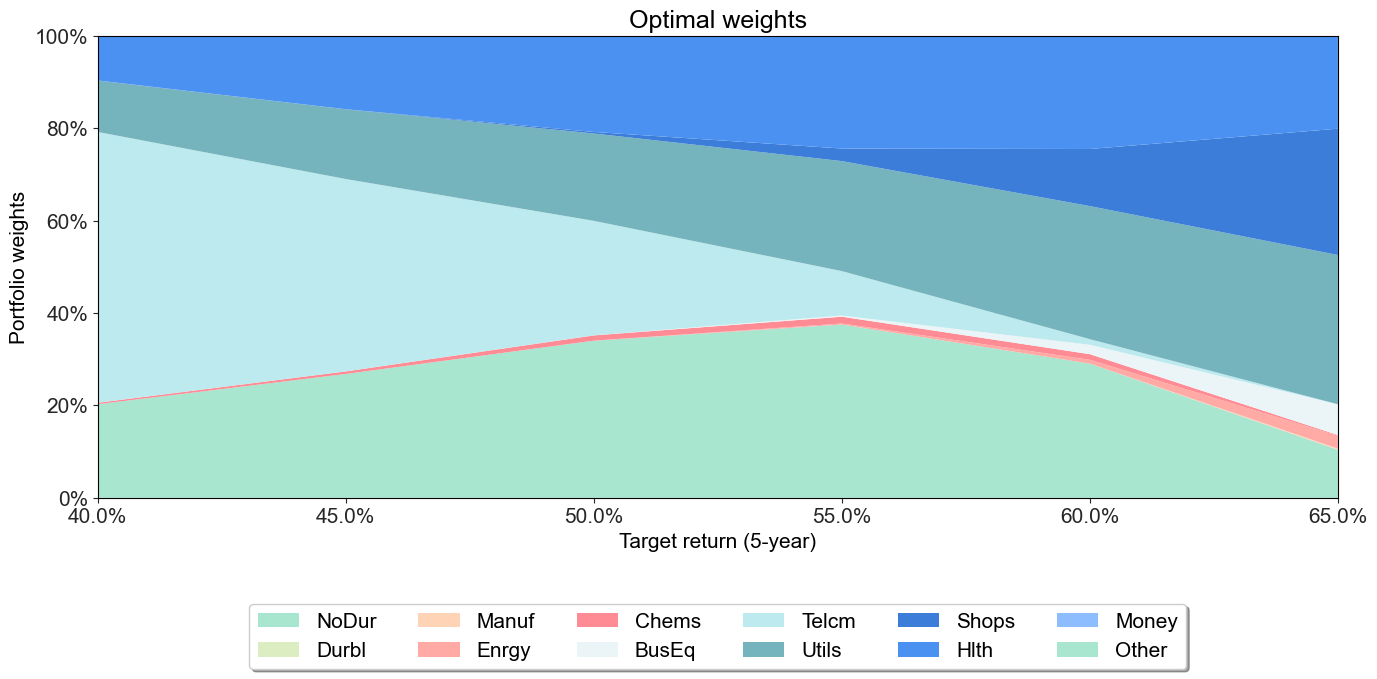

In [53]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(np.array(targets) - 1.0, optimal_port_resampled_weights_buy_and_hold.T, labels=asset_list);
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=6);
ax.set_xlabel("Target return (5-year)")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights");